# NetShare Modbus pipeline

A guide on how to run the whole NetShare pipeline from a `PCAP` file containing modbus packets to final generated synthetic results on using your own machine, so that you can fully utilize the capability of the machine and customize the pipeline as you wanted.

Notice that the pipeline needs to be installed and configured on the machine to be used, so if you only want a quick demo, we recommend you to use the Google Colab version [here](https://colab.research.google.com/drive/10EzjAZOl6CPelxFswphxbBDvsAQtoReF#scrollTo=uYlAIox_Y00X); if you only want to use the standard NetShare pipeline, we recommend you to use the web version here.

## Install environment

Before you start to use NetShare, you will need to install the required environment. Because NetShare is recommended to be installed in Anaconda, and you are using Jupyter Notebook, so first you need to install the environment **outside** this notebook, and then run this notebook inside that environment to run the code in the notebook.

First, we assume that you have Anaconda installed. Else, please see [here](https://www.anaconda.com/).

Now, create a new virtual environment in Anaconda using this following command. Once again, run these commands **outside** this notebook on your own machine.
```bash
conda create --name NetShare python=3.9
```

Then activate the newly created environment using the following command:
```bash
conda activate NetShare
```

Now clone the repositories to your machine under the same repository with this notebook and install them:
```bash
git clone -b modbus_processors https://github.com/HaozheSong/NetShare.git
pip3 install -e NetShare/NetShare/
pip3 install -e NetShare/SDMetrics_timeseries/
```

Finally, install Jupyter notebook in the new environment and start this notebook in the new environment.
```bash
conda install jupyter
jupyter notebook
```
Your environment should be ready now.

## NetShare Preprocess Pipeline

Before you can feed `PCAP` file data into NetShare to train a model/generate synthetic results, it needs to be preprocessed into the expected `CSV` input format. First we provide a generalized preprocess pipeline for converting pcap files into csv files for `Modbus` (and almost any other protocols), and also gives an example guide on how to use it.

The preprocess guide will be provided by explaining the elements in the pipeline one by one in the order they appear in the pipeline and give examples. By following this guide you should be able to use the pipeline to convert `PCAP` files into `CSV` files. You can also skip some of the steps if you don't need them (e.g., if you already have a `Zeek` log file, you can skip the first two elements).

Overview of the preprocess pipeline:

![Preprocess pipeline](https://raw.githubusercontent.com/HaozheSong/NetShare/modbus_processors/NetShare/examples/modbus/flow_diagram.png)

### Elements

####  *.pcap

Any packet capture file (dataset) that wants to be used as the input of NetShare.


#### Zeek

Use Zeek as the process tool to parse `*.pcap` files to json log files.

##### Installation

Full installation instructions can be found [here](https://docs.zeek.org/en/lts/install.html).

Here we provide the installation of `Zeek` on some systems. If you can't find your system here, you can follow the full installation instructions above and try to install it yourself.

###### Installation on macOS

If your system is macOS, `Zeek` can be installed using homebrew.

First running the following command to install homebrew:

In [ ]:
! /bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

Use the following command to verify installation:

In [1]:
! brew --version

Homebrew 4.0.28
Homebrew/homebrew-core (git revision 5c5075d96b1; last commit 2023-03-24)
Homebrew/homebrew-cask (git revision ba10cd38d2; last commit 2023-03-25)


Then running the following command to install Xcode or the "Command Line Tools":

In [ ]:
! xcode-select --install

Use the following command to verify installation:

In [2]:
! xcode-select -p

/Library/Developer/CommandLineTools


Finally, use the following command to install Zeek:

In [ ]:
! brew install zeek

And use the following command to verify installation:

In [3]:
! zeek --version

zeek version 5.2.2


###### Installation on Ubuntu

If your system is Ubuntu, you can install `Zeek` by following these instructions.

First, run the following command to update the system with latest available packages:

In [ ]:
! sudo apt-get update -y

Then run the following command to install all required dependencies of `Zeek`:

In [ ]:
! sudo apt-get install curl gnupg2 wget -y

Because by default, `Zeek` is not included in the Ubuntu default repository, so you will need to add the Zeek repository to the system. Run the following command to download and add the Zeek GPG key. Notice that you may need to change the `20.04` in the following two commands to your own Ubuntu version.

In [ ]:
! curl -fsSL https://download.opensuse.org/repositories/security:zeek/xUbuntu_20.04/Release.key | gpg --dearmor | sudo tee /etc/apt/trusted.gpg.d/security_zeek.gpg > /dev/null

Then run the following command to add the Zeek repository to APT:

In [ ]:
! echo 'deb http://download.opensuse.org/repositories/security:/zeek/xUbuntu_20.04/ /' | sudo tee /etc/apt/sources.list.d/security:zeek.list

Finally, run the following commands in the terminal to  update the repository cache and install `Zeek`. During the installation, you will be asked to provide some postfix settings. You can follow the instructions and choose the settings according to your need, or you can simply choose `No configuration`.

In [ ]:
! sudo apt-get update -y
! sudo apt-get install zeek -y

Now you need to add `Zeek` to the system path. You can do this by running the following commands:

In [ ]:
import os
os.environ['PATH'] += ':/opt/zeek/bin'

You can also permanently add `Zeek` to the system path by modifying `~/.bashrc`.

Now, use the following command to verify installation:

In [ ]:
! zeek --version

##### Usage

Prepare the `PCAP` file that you want to parse. You can download an example by running this command:



In [1]:
! wget https://github.com/antoine-lemay/Modbus_dataset/raw/master/run8.pcap

--2023-07-26 00:18:08--  https://github.com/antoine-lemay/Modbus_dataset/raw/master/run8.pcap
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/antoine-lemay/Modbus_dataset/master/run8.pcap [following]
--2023-07-26 00:18:09--  https://raw.githubusercontent.com/antoine-lemay/Modbus_dataset/master/run8.pcap
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7190064 (6.9M) [application/octet-stream]
Saving to: ‘run8.pcap.1’

run8.pcap.1         100%[===================>]   6.86M  8.88MB/s    in 0.8s    

2023-07-26 00:18:10 (8.88 MB/s) - ‘run8.pcap.1’ saved [7190064/7190064]



Then change to the working directory, and run the following zeek command:

In [2]:
! mkdir zeek
! cd zeek && zeek -C -r ../run8.pcap LogAscii::use_json=T

In the command, `../run8.pcap` should be replaced with the desired `PCAP` file path.

Option `-C` means to ignore invalid IP Checksums, `-r` means to parse an existing `PCAP` file, and `LogAscii::use_json=T` means to output results in `JSON` format (which is important, because the pipeline was designed to handle `JSON` log format). The results will be generated in the working directory. Other custom or extra scripts can also be added after the command to be loaded. Full instructions can be found [here](https://docs.zeek.org/en/master/quickstart.html).

#### input file

Input file of `Stage1Preprocessor` class.

Currently supported format:

*   Output file from `Zeek` (`*.log`) in `JSON` format
*   `CSV` file (`*.csv`)

#### config.json

A configuration file to indicate file path and fields that need to be extracted.

##### Example

The example config file is at `./config.json`.

The content of the file is shown here:

```json
{
  "processors": {
    "preprocessors": [
      "Stage1Preprocessor",
      "csv_pre_processor"
    ],
    "post_csv": true
  },
  "input_file": {
    "format": "zeek_log_json"
  },
  "global_config": {
    "overwrite": true,
    "dataset_type": "netflow",
    "n_chunks": 1,
    "dp": false
  },
  "default": "single_event_per_row.json",
  "pre_post_processor": {
    "class": "NetsharePrePostProcessor",
    "config": {
      "word2vec": {
        "vec_size": 10,
        "model_name": "word2vec_vecSize",
        "annoy_n_trees": 100,
        "pretrain_model_path": null
      },
      "metadata": [],
      "timeseries": []
    }
  },
  "model": {
    "class": "DoppelGANgerTorchModel",
    "config": {
      "batch_size": 100,
      "sample_len": [
        10
      ],
      "sample_len_expand": true,
      "epochs": 5,
      "extra_checkpoint_freq": 1,
      "epoch_checkpoint_freq": 5
    }
  },
  "fields": {
    "timestamp": [
      {
        "name": "ts",
        "parse": "second2micro",
        "format": "timestamp",
        "encoding": "timestamp"
      }
    ],
    "metadata": [
      {
        "name": "id.orig_h",
        "parse": "ip_quad2int",
        "format": "integer",
        "encoding": "bit"
      },
      {
        "name": "id.orig_p",
        "format": "integer",
        "encoding": "word_port"
      },
      {
        "name": "id.resp_h",
        "parse": "ip_quad2int",
        "format": "integer",
        "abnormal": true,
        "encoding": "bit"
      },
      {
        "name": "id.resp_p",
        "format": "integer",
        "encoding": "word_port"
      }
    ],
    "timeseries": [
      {
        "name": "func",
        "parse": "modbus_func2code",
        "format": "integer",
        "encoding": "categorical"
      }
    ]
  }
}
```

##### Explanation

* `input_file`: optional, configuration of the input file.
    * `format`: optional, format of the input file. Default: `zeek_log_json`. Supported choices:
        * `zeek_log_json`: Output file from `Zeek` (*.log) in `JSON` format;
        * `csv`: `CSV` file (*.csv).
* `fields`: required, fields in the input file that need to be extracted. Each field should be put under one of the three categories: `timestamp`, `metadata` or `timeseries`.
    * `name`: required, key of the field that appeared in the input file.
    * `parse`: optional, name of the parsing function to be applied on the field defined in `pasre_func.py`. Must ensure that the function exist in `parse_func.py`. Default: `None`.
    * `format`: optional, output format of the field (after parsing). Default: `str`.
    * `abnormal`: optional, if this field needs abnormal handling. Default: `false`.
    * `encoding`: required, the encoding method to be used on the field when training NetShare model. Please refer to the next section for more details.
  
The rest of the part are config about the NetShare model. You can leave them unchanged.

###### Encoding

Currently, NetShare supports the following field configs:

* `bit` encoding: Bit field (encoded as bit strings) e.g.,
```json
{
    "column": "srcip",
    "type": "integer",
    "encoding": "bit",
    "n_bits": 32
}
```

* `word2vec_port` encoding: Word2Vec field (encoded as Word2Vec vectors), e.g.,
```json
{
    "column": "srcport",
    "type": "integer",
    "encoding": "word2vec_port"
}
```

* `categorical` encoding: Categorical field (encoded as one-hot encoding), e.g.,
```json
{
    "column": "type",
    "type": "string",
    "encoding": "categorical"
}
```
Here type can be `string` or `integer`.

* `float` encoding: Continuous field, e.g.,
```json
{
    "column": "pkt",
    "type": "float",
    "normalization": "ZERO_ONE",
    "log1p_norm": true
}
```

You should choose to config your fields as needed according to the "nearest match", and fill the encoding method into the config file.

#### parse_func.py

This is a python file that contains customized parsing functions.

##### Example

Here are three example parsing functions. You can use them as you needed. If you want to implement new ones, you can add your new functions under `NetShare/NetShare/netshare/pre_post_processors/parse_func.py` according to the explanation below.

```python
import socket

def second2micro(second):
    """
    :param second: Time in second
    :return: Time in microsecond
    """
    return second * 1000000


def ip_quad2int(ip_quad_string):
    """
    Parse a dotted-quad string IP address (e.g., 192.168.0.0) to a unsigned int
    by first convert the IP address back to 32-bit binary format and then covert the binary to decimal.

    :param ip_quad_string: IP address in dotted-quad string format (e.g., 192.168.0.0)
    :return: Converted unsigned int result
    """
    # Bytes format of the IP address (192.168.0.0 -> b'\xc0\xa8\x00\x00)
    ip_bytes = socket.inet_aton(ip_quad_string)
    # Convert the bytes to a decimal with big endian byte order
    return int.from_bytes(ip_bytes, 'big')


def modbus_func2code(func_name):
    """
    :param func_name: Modbus function name
    :return: Corresponding modbus function code
    """
    if func_name == 'READ_COILS':
        return 1
    elif func_name == 'READ_DISCRETE_INPUTS':
        return 2
    elif func_name == 'READ_HOLDING_REGISTERS':
        return 3
    elif func_name == 'READ_INPUT_REGISTERS':
        return 4
    elif func_name == 'WRITE_SINGLE_COIL':
        return 5
    elif func_name == 'WRITE_SINGLE_REGISTER':
        return 6
    else:
        return 0
```

##### Explanation

* Each parsing function should take one parameter as input (the original field value) and return the parsed value.

* The returned value should be consistent with the output `format` (see previous section).

* Each function name that appears in the `config.json` file must be implemented here.

* If you need to implement more customized parsing functions, just add functions as you needed in `parse_func.py` and put the names in the `parse` field of the config file as explained above.

* Abnormal handling:
    * Definition of abnormal:
        * Value of numbers less than 0;
        * Empty field.
    * If detected abnormal, the value of the field will be changed into `unavailable` (if output format is `str`) or `0` (if output format is number);
    * If not, the original value will not be changed.


#### Stage1Preprocessor.py

This is a python class that contains a function `preprocess`, which will do the preprocess according to the configuration file. 

You can find the details under `NetShare/NetShare/netshare/pre_post_processors/stage1_preprocessor.py`.

After Stage1 Preprocessor, you will get a preprocessed `CSV` file. The values in it has been customizedly parsed according to `parse_func.py`.

#### CSVPreprocessor

The main goal of this preprocessor is to automatically generate the config file of NetShare according to the encoding methods you chose in the previous `config.json`. After this preprocessor, you are ready to run and train the NetShare model and generate synthetic data.

## NetShare Synthetic Data Generation

Here, we will provide guides on running the NetShare on your local machine.

### Usage

First use the following command to move the generated result from `Zeek`. Notice: if you didn't use `Zeek`, you should move your own `.log` file or `.csv` file to the working directory.

In [3]:
! mv zeek/modbus.log original.log

The working directory is under `NetShare/NetShare/examples/modbus/`. In the working directory, `driver.py` is the entrance Python file to start the whole training pipeline; other files are the input dataset and `config.json` from the previous sections.

Now run the following command to start the preprocess, train and generation of NetShare. Notice: it may take a while to train the model.

In [ ]:
! python driver.py

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
Stage1Preprocessor
csv_pre_processor
Ray is disabled
/Users/sunnyyao666/PycharmProjects/integration/NetShare/NetShare/netshare/generators/generator.py:139: UserWarning: /Users/sunnyyao666/PycharmProjects/integration/NetShare/NetShare/results/modbus/pre_processed_data already exists. You are overwriting the results.
  warnings.warn(
NetsharePrePostProcessor._pre_process
/Users/sunnyyao666/PycharmProjects/integration/NetShare/NetShare/results/modbus/pre_processed_data/pre_processed.csv
dataset type: netflow
metadata cols: ['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p']
word2vec cols: ['id.orig_p', 'id.resp_p']
Training Word2Vec model from scratch...
07/26/2023 00:35:10:WARNING:consider setting layer size to a multiple of 4 for greater performance
07/26/2023 00:35:11:WARNING:under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
Word2Vec model is saved at /Users

### Results

The results can be viewed under `NetShare/NetShare/results/modbus` and in your browser.

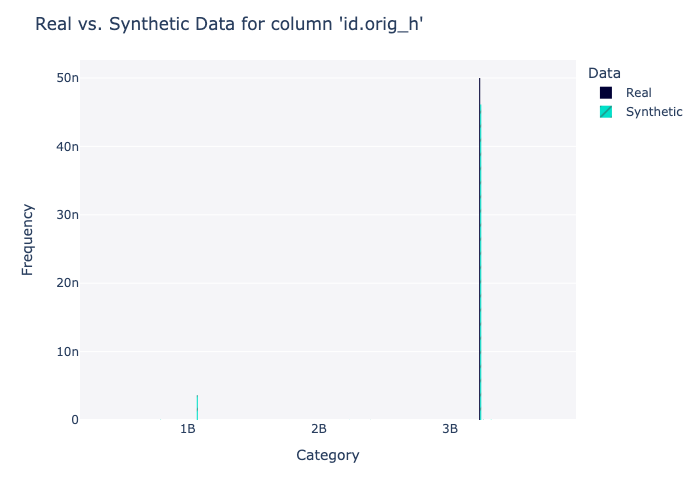

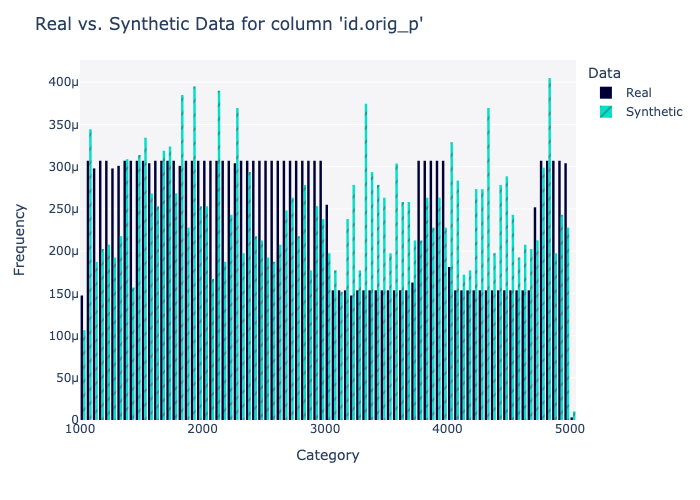

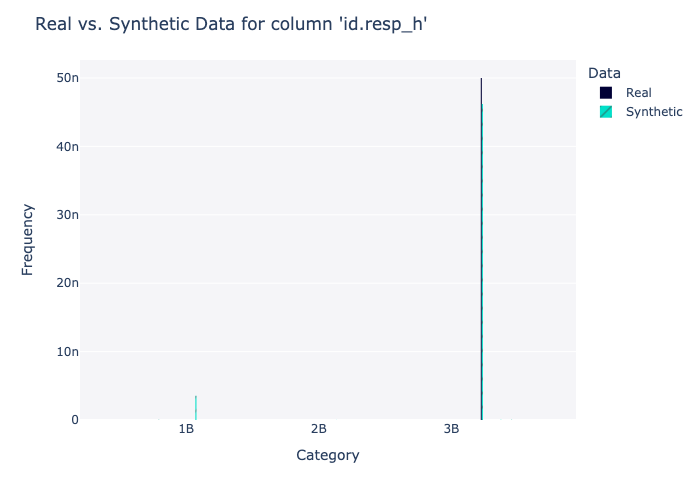

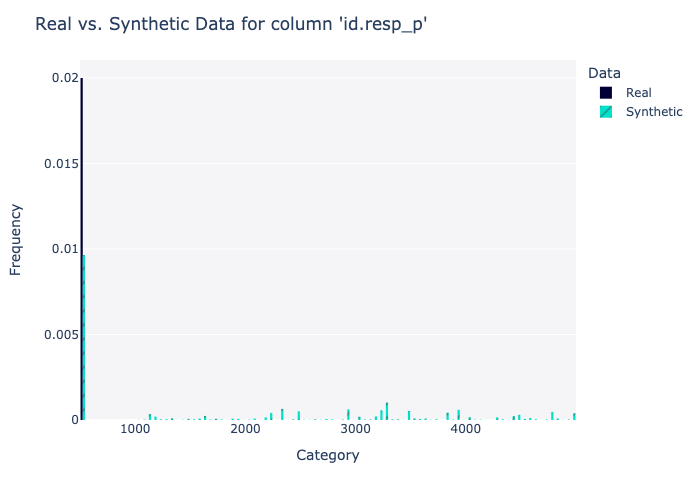

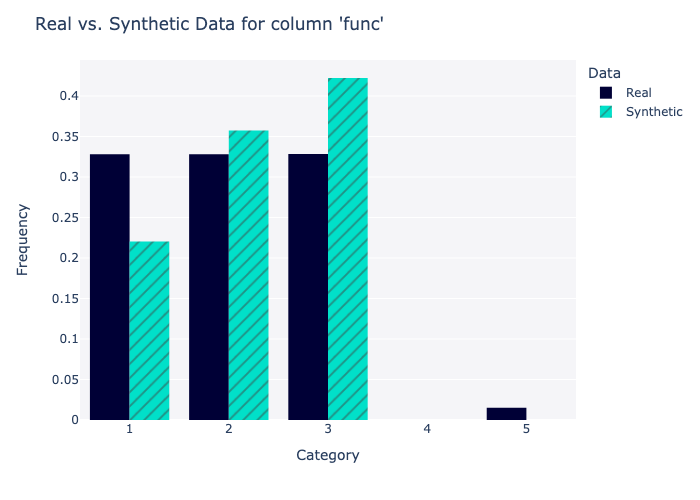

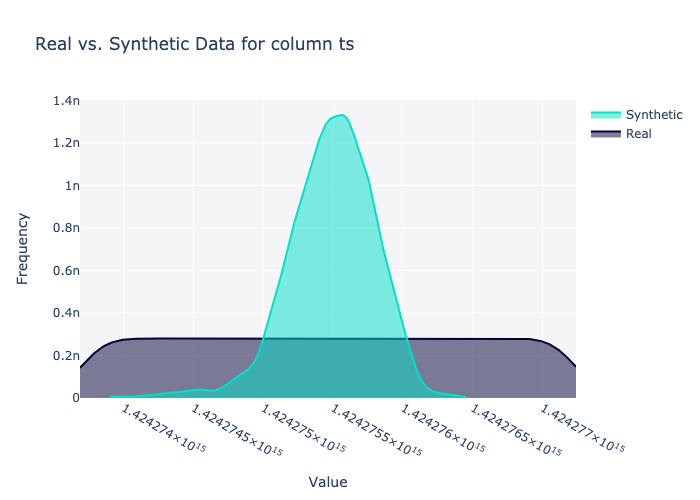

In [4]:
from IPython.display import display, Image

path_list = ['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'func', 'ts']

for path in path_list:
    img_path = '../../results/modbus/result/[\'' + path + '\'].png'
    display(Image(img_path))